# Grounding and Learning in Logic Tensor Networks (LTN)

LTN consists of a non-logical part (the signature) and logical connectives and quantifiers. This tutorial explains the 
Signature of LTN (non-logical symbols)
* **constants** denote individuals from some space of real numbers $\mathbb{R}^k$. We call this the **domain**
* **functions** can be any mathematical function either pre-defined or learnable. Examples of functions can be distance functions, similarities etc. Functions can be defined using any computational graph in Tensorflow. They can be linear functions, Deep Neural Networks.
* **predicates** are represented as functions that map from some n-ary domain to a real from $[0,1]$.
* **connectives** -- not, and, or, implies -- are modeled using t-norms
* **quantifiers** are based on domain sample aggregations

This tutorial explains how to ground predicates that need to be learned (optimized). It expects some basic familiarity of the other parts of LTN.

In [1]:
# initialization. we need numpy and matplotlib
# this tutorial uses the LTN wrapper
import logging;logging.basicConfig(level=logging.INFO);
import numpy as np;
import matplotlib.pyplot as plt; 
import tensorflow as tf;

# adding parent directory to sys.path (ltnw is in parent dir)
import sys, os
sys.path.insert(0,os.path.normpath(os.path.join(os.path.abspath(''),os.path.pardir)))
import logictensornetworks_wrapper as ltnw;
ltnw.SESSION=tf.InteractiveSession() # we will use an interactive session

We use the following example. The domain is the square $[0,4]\times [0,4]$.

We have a set of examples of the class $\color{red}A$.
We also know that the membership function of $\color{red}A$ is $$\sigma(w_1\cdot x + w_2\cdot y + w_3)$$ with $\sigma(x)$ the sigmoid function $\frac{1}{1+e^{-x}}$.

We now define a theory/knowledgebase, where $A$ is defined using examples. We use $\mathrm{ltwn.axiom}$ to construct formulas that we want to hold.

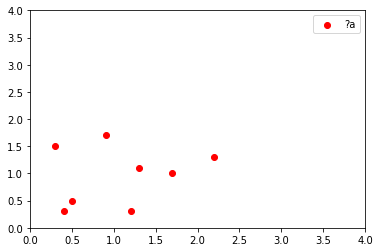

In [2]:
# define variable,  
ltnw.variable("?a",[[0.4,0.3],[1.2,0.3],[2.2,1.3],[1.7,1.0],[0.5,0.5],[0.3, 1.5],[1.3, 1.1],[0.9, 1.7]]);

# define predicate
w_A = tf.Variable(np.random.randn(), name="weight")
b_A = tf.Variable(np.random.randn(), name="bias")
ltnw.predicate("A",2,pred_definition=lambda x: tf.sigmoid(tf.add(tf.reduce_sum(tf.multiply(x,w_A),axis=1),b_A)))

# assert that for all ?a, A holds
ltnw.axiom("forall ?a: A(?a)")

# show variable individuals as points
fig, ax = plt.subplots();plt.xlim(0,4);plt.ylim(0,4);
plt.scatter(ltnw.variable("?a").eval()[:,0],ltnw.variable("?a").eval()[:,1],color="red",label="?a")
plt.legend()

We have a set of examples of the class $\color{blue}B$. The membership function of $\color{blue}B$ is the same as for $\color{red}A$

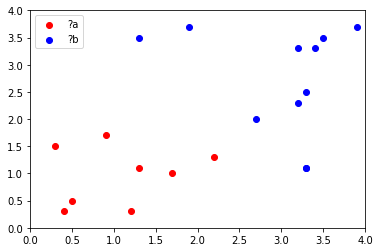

In [3]:
# define variable
ltnw.variable("?b",[[3.4,3.3],[3.2,3.3],[3.2,2.3],[2.7,2.0],[3.5,3.5],[3.3, 2.5],[3.3, 1.1],[1.9, 3.7],[1.3, 3.5],[3.3, 1.1],[3.9, 3.7]])

# define predicate
w_B = tf.Variable(np.random.randn(), name="weight")
b_B = tf.Variable(np.random.randn(), name="bias")
ltnw.predicate("B",2,pred_definition=lambda x: tf.sigmoid(tf.add(tf.reduce_sum(tf.multiply(x,w_B),axis=1),b_B)))

# define that for all ?b B holds
ltnw.axiom("forall ?b: B(?b)")

# show variable individuals as points
fig, ax = plt.subplots();plt.xlim(0,4);plt.ylim(0,4);
plt.scatter(ltnw.variable("?a").eval()[:,0],ltnw.variable("?a").eval()[:,1],color="red",label="?a")
plt.scatter(ltnw.variable("?b").eval()[:,0],ltnw.variable("?b").eval()[:,1],color="blue",label="?b")
plt.legend()

We know $\color{red}A$ and $\color{blue}B$ are disjoint

In [4]:
ltnw.variable("?x",np.concatenate([ltnw.variable("?a").eval(),ltnw.variable("?b").eval()],axis=0))

ltnw.axiom("forall ?x: A(?x) -> ~B(?x)");
ltnw.axiom("forall ?x: ~A(?x) -> B(?x)");
ltnw.axiom("forall ?x: B(?x) -> ~A(?x)");
ltnw.axiom("forall ?x: ~B(?x) -> A(?x)");

So here is our theory

In [5]:
print("\n".join(sorted(ltnw.AXIOMS.keys())))

forall ?a: A(?a)
forall ?b: B(?b)
forall ?x: A(?x) -> ~B(?x)
forall ?x: B(?x) -> ~A(?x)
forall ?x: ~A(?x) -> B(?x)
forall ?x: ~B(?x) -> A(?x)


We can now optimize the knowledgebase to maximize satisfiability of the formulas

In [6]:
# aggregate formulas
aggregated_formulas=tf.reduce_mean(tf.concat(list(ltnw.AXIOMS.values()),axis=0))
# choose an optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# turn satisfiability into loss
loss=optimizer.minimize(-aggregated_formulas)

# initialize all Tensorflow variables/parameters (w_A,b_A,w_B,b_B)
ltnw.SESSION.run(tf.global_variables_initializer())
print("initial satisfiability level %.2f" % ltnw.SESSION.run(aggregated_formulas))

initial satisfiability level 0.83


In [7]:
track_sat_levels=100
for i in range(5000):
    if i % track_sat_levels == 0:
        sat_level=ltnw.SESSION.run(aggregated_formulas)
        logging.getLogger(__name__).info("TRAINING %s sat level -----> %s" % (i,sat_level))

    ltnw.SESSION.run(loss)


INFO:__main__:TRAINING 0 sat level -----> 0.8335902
INFO:__main__:TRAINING 100 sat level -----> 0.8499883
INFO:__main__:TRAINING 200 sat level -----> 0.88080096
INFO:__main__:TRAINING 300 sat level -----> 0.8980463
INFO:__main__:TRAINING 400 sat level -----> 0.903495
INFO:__main__:TRAINING 500 sat level -----> 0.90305096
INFO:__main__:TRAINING 600 sat level -----> 0.9067624
INFO:__main__:TRAINING 700 sat level -----> 0.9075987
INFO:__main__:TRAINING 800 sat level -----> 0.9077949
INFO:__main__:TRAINING 900 sat level -----> 0.9114159
INFO:__main__:TRAINING 1000 sat level -----> 0.91313
INFO:__main__:TRAINING 1100 sat level -----> 0.91581935
INFO:__main__:TRAINING 1200 sat level -----> 0.9152872
INFO:__main__:TRAINING 1300 sat level -----> 0.9198215
INFO:__main__:TRAINING 1400 sat level -----> 0.92178893
INFO:__main__:TRAINING 1500 sat level -----> 0.9211448
INFO:__main__:TRAINING 1600 sat level -----> 0.9245048
INFO:__main__:TRAINING 1700 sat level -----> 0.92562646
INFO:__main__:TRAINI

We can now ask a series of questions (queries). The first way is to query the knowledgebase is to generate a formula and then just call eval (which is executed in a Tensorflow Interactive session).

In [8]:
ltnw.axiom("forall ?a: A(?a)").eval()

array([0.81416804], dtype=float32)

Another way of querying the knowledgebase is to use the ltnw ask function. Here we query whether $A$ holds for all positive examples for $B$.

In [9]:
ltnw.ask("forall ?b: A(?b)")

array([0.01895745], dtype=float32)

Here we query whether $B$ holds for all positive examples for $B$.

In [10]:
ltnw.ask("forall ?b: B(?b)")

array([0.8966524], dtype=float32)

Here we query whether $A$ holds for all positive examples for $B$.

In [11]:
ltnw.ask("forall ?b: A(?b)")

array([0.01895745], dtype=float32)

Here we query whether $A$ holds for all samples.

In [12]:
ltnw.ask("forall ?x: A(?x) -> ~B(?x)")

array([0.9998336], dtype=float32)

Here we query whether $B$ implies not $A$ holds for all samples.

In [13]:
ltnw.ask("forall ?x: B(?x) -> ~A(?x)")

array([0.9998336], dtype=float32)

Here we query whether $B$ holds for all samples.

In [14]:
ltnw.ask("forall ?x: B(?x)")

array([0.12482198], dtype=float32)

Here we query whether $A$ holds for all samples.

In [15]:
ltnw.ask("forall ?x: A(?x)")

array([0.03219942], dtype=float32)

Here we query whether $A$ or $B$ holds for all samples.

In [16]:
ltnw.ask("forall ?x: A(?x) | B(?x)")

array([0.9999982], dtype=float32)